In [1]:
import os 
os.chdir('../../')
os.environ["DPM_TQDM"] = "False"

In [2]:
from backbones.dit import DiT

# 사용 예
model = DiT(trainable=True)
print(model)

/home/scpark/miniconda3/envs/sana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]An error occurred while trying to fetch /home/scpark/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/scpark/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a632f08807fbaab0b704d0/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  67%|██████▋   | 2/3 [00:00<00:00, 18.63it/s]An error occurred while trying to fetch /home/scpark/.cache/huggingface/hub/models--facebook--DiT-XL-2-256/snapshots/eab87f77abd5aef071a

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_class_images(pixel_samples, class_ids=None, figsize_per_image=1.5, display_title=""):
    samples = list(pixel_samples)
    processed = []
    for img in samples:
        if isinstance(img, Image.Image):
            arr = np.array(img)
        else:
            arr = np.array(img)
            if arr.ndim == 3 and arr.shape[0] in (1,3):
                arr = arr.transpose(1, 2, 0)
        processed.append(arr)

    n = len(processed)
    if class_ids is None:
        class_ids = list(range(n))

    fig, axes = plt.subplots(1, n, figsize=(n * figsize_per_image, figsize_per_image))
    if n == 1:
        axes = [axes]

    # 전체 제목 추가
    if display_title:
        fig.suptitle(display_title, fontsize=10, y=1.1)  # y 값을 1.02로 올려서 제목을 위로 이동
    # 플롯 레이아웃 조정: top을 낮춰서 제목과 플롯 사이에 공간 확보
    
    for ax, img_arr, lbl in zip(axes, processed, class_ids):
        ax.imshow(img_arr)
        ax.axis("off")
        ax.set_title(f"Class {lbl}", fontsize=8)

    plt.show()


In [4]:
import torch
import torch.nn.functional as F
from torch import amp
from solvers.dual.static.gdual_pc_hidden_box_solver import GDual_PC_Hidden_Box_Solver
from solvers.dual.static.gdual_pc_box_solver import GDual_PC_Box_Solver

class_ids = np.array([1, 90, 130, 279, 281, 323, 386, 417, 424, 432, 444, 468, 550, 562, 852, 933, 981, 992])[:14]
model_fn, noise_schedule, latents = model.get_model_fn(pos_conds=class_ids, guidance_scale=1.375)

print(class_ids)

[  1  90 130 279 281 323 386 417 424 432 444 468 550 562]


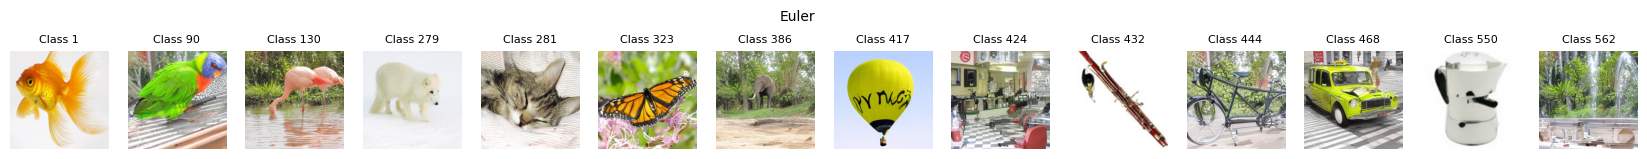

In [5]:
from solvers.euler_solver import Euler_Solver

with torch.no_grad():
    solver = Euler_Solver(model_fn, noise_schedule, algorithm_type="data_prediction")
    euler_latents = solver.sample(latents, steps=200, skip_type="time_uniform")['samples']
    euler_samples = model.decode_vae(euler_latents)
    display_class_images(euler_samples, class_ids, display_title='Euler')


In [6]:
device = 'cuda:0'
#solver = GDual_PC_Hidden_Box_Solver(model_fn, noise_schedule, steps=5, skip_type="time_uniform", hidden_dim=128, param_dim=(4, 1, 1))
solver = GDual_PC_Box_Solver(model_fn, noise_schedule, steps=5, skip_type="time_uniform", param_dim=(4, 1, 1))
solver = solver.to(device)

optimizer = torch.optim.AdamW(solver.parameters(), lr=1e-3)
scaler = amp.GradScaler()
print('done')

done


In [7]:
import os
import numpy as np
import torch

euler_dir = 'samplings/dit/train/dit_train_0/'
def get_samples(euler_dir, N=4):
    euler_pts = [os.path.join(euler_dir, f) for f in os.listdir(euler_dir) if f.endswith('.pt')]
    noises = []
    samples = []
    conds = []
    for index in np.random.randint(0, len(euler_pts), N):
        outputs = torch.load(euler_pts[index], weights_only=True)
        noises.append(outputs['noise'])
        samples.append(outputs['sample'])
        conds.append(outputs['cond'])
    return torch.stack(noises), torch.stack(samples), conds

noises, samples, conds = get_samples(euler_dir, N=4)
print(noises.shape, samples.shape)
print(conds)

torch.Size([4, 4, 32, 32]) torch.Size([4, 4, 32, 32])
[356, 243, 818, 400]


  0%|          | 0/1000 [00:00<?, ?it/s]

Loss : tensor(0.1544, device='cuda:0')


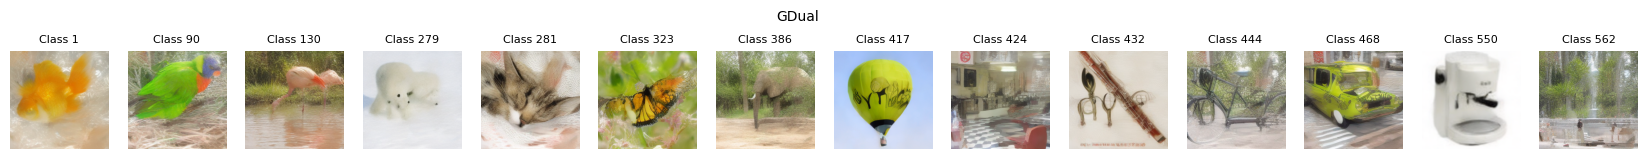

  2%|▏         | 20/1000 [01:07<55:07,  3.37s/it, loss=0.0862]


KeyboardInterrupt: 

In [8]:
from tqdm import tqdm

pbar = tqdm(range(1000))
for iter in pbar:
    if iter % 100 == 0:
        with torch.no_grad():
            preds = solver.sample(latents, model_fn=model_fn)
            loss = F.mse_loss(preds, euler_latents)
            print('Loss :', loss)
            samples = model.decode_vae(preds)
            display_class_images(samples, class_ids, display_title='GDual')

    optimizer.zero_grad(set_to_none=True)
    with amp.autocast(device_type=device, dtype=torch.bfloat16):
        noises, samples, conds = get_samples(euler_dir, N=16)
        noises = noises.to(torch.bfloat16).to(device)
        samples = samples.to(torch.bfloat16).to(device)
        model_fn_train, _, _ = model.get_model_fn(pos_conds=conds, guidance_scale=1.375)
        preds = solver.sample(noises, model_fn=model_fn_train)
        loss = F.mse_loss(preds, samples)

        pbar.set_postfix({'loss': loss.item()})

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

print('done')

In [ ]:
torch.__version__

'2.4.0+cu121'